In [11]:
# Імпорти
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Завантаження даних
df = pd.read_csv('nasa.csv')

# Вибір числових фіч
X = df.select_dtypes(include='number').drop(columns=['Neo Reference ID'], errors='ignore')

# В якості "true labels" візьмемо Hazardous (True/False) для supervised evaluation
y = df['Hazardous'].astype(int)

# Масштабування
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X shape:", X_scaled.shape)
print("y distribution:", np.bincount(y))


X shape: (4687, 34)
y distribution: [3932  755]


In [12]:
# KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
labels_km = kmeans.fit_predict(X_scaled)

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels_db = dbscan.fit_predict(X_scaled)

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=2)
labels_ag = agglo.fit_predict(X_scaled)

# Spectral Clustering
spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
labels_sp = spectral.fit_predict(X_scaled)


In [13]:
def unsupervised_metrics(X, labels, name):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    sil = silhouette_score(X, labels) if n_clusters>1 else -1
    db = davies_bouldin_score(X, labels) if n_clusters>1 else -1
    ch = calinski_harabasz_score(X, labels) if n_clusters>1 else -1
    n_outliers = np.sum(labels==-1) if -1 in labels else 0
    print(f"{name}: clusters={n_clusters}, outliers={n_outliers}, Silhouette={sil:.3f}, DB={db:.3f}, CH={ch:.3f}")

unsupervised_metrics(X_scaled, labels_km, "KMeans")
unsupervised_metrics(X_scaled, labels_db, "DBSCAN")
unsupervised_metrics(X_scaled, labels_ag, "Agglomerative")
unsupervised_metrics(X_scaled, labels_sp, "Spectral")


KMeans: clusters=2, outliers=0, Silhouette=0.206, DB=1.962, CH=919.868
DBSCAN: clusters=13, outliers=4599, Silhouette=-0.324, DB=1.395, CH=4.244
Agglomerative: clusters=2, outliers=0, Silhouette=0.183, DB=2.431, CH=571.148
Spectral: clusters=2, outliers=0, Silhouette=0.298, DB=0.917, CH=27.153


In [14]:
def supervised_metrics(y_true, y_pred, name):
    nmi = normalized_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    fm = fowlkes_mallows_score(y_true, y_pred)
    print(f"{name}: NMI={nmi:.3f}, ARI={ari:.3f}, Fowlkes-Mallows={fm:.3f}")

supervised_metrics(y, labels_km, "KMeans")
supervised_metrics(y, labels_db, "DBSCAN")
supervised_metrics(y, labels_ag, "Agglomerative")
supervised_metrics(y, labels_sp, "Spectral")


KMeans: NMI=0.041, ARI=0.100, Fowlkes-Mallows=0.679
DBSCAN: NMI=0.011, ARI=-0.028, Fowlkes-Mallows=0.833
Agglomerative: NMI=0.002, ARI=0.019, Fowlkes-Mallows=0.666
Spectral: NMI=0.007, ARI=0.013, Fowlkes-Mallows=0.854


In [15]:
# PCA
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)


Explained variance ratio: [0.31661182 0.16641003 0.12583599]


c:\Users\Користувач\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


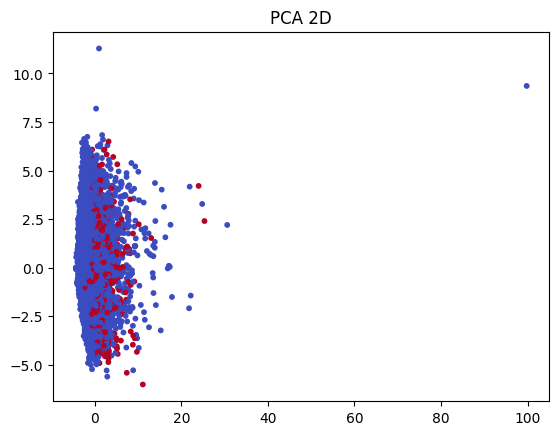

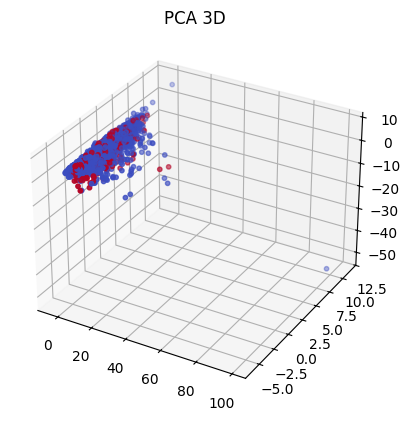

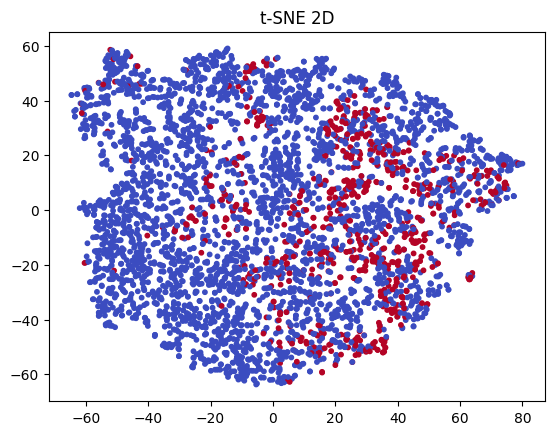

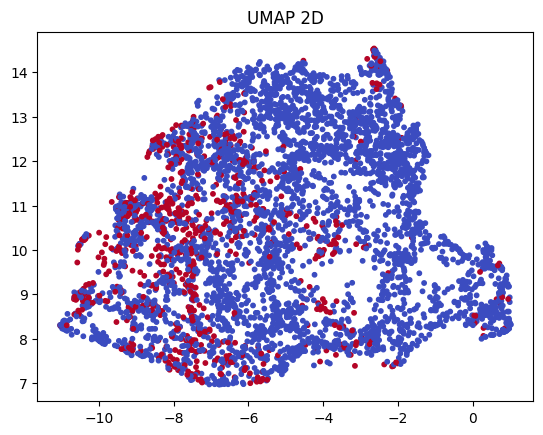

In [16]:
# PCA 2D
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', s=10)
plt.title("PCA 2D")
plt.show()

# PCA 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=y, cmap='coolwarm', s=10)
plt.title("PCA 3D")
plt.show()

# t-SNE 2D
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='coolwarm', s=10)
plt.title("t-SNE 2D")
plt.show()

# UMAP 2D
plt.scatter(X_umap[:,0], X_umap[:,1], c=y, cmap='coolwarm', s=10)
plt.title("UMAP 2D")
plt.show()


In [17]:
# KMeans on PCA
labels_km_pca = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)
supervised_metrics(y, labels_km_pca, "KMeans PCA")

# DBSCAN on UMAP
labels_db_umap = DBSCAN(eps=0.5, min_samples=5).fit_predict(X_umap)
unsupervised_metrics(X_umap, labels_db_umap, "DBSCAN UMAP")
supervised_metrics(y, labels_db_umap, "DBSCAN UMAP")


KMeans PCA: NMI=0.035, ARI=0.094, Fowlkes-Mallows=0.680
DBSCAN UMAP: clusters=1, outliers=0, Silhouette=-1.000, DB=-1.000, CH=-1.000
DBSCAN UMAP: NMI=0.000, ARI=0.000, Fowlkes-Mallows=0.854


In [18]:
# DBSCAN eps tuning
for eps in [0.3, 0.5, 0.7, 1.0]:
    labels = DBSCAN(eps=eps, min_samples=5).fit_predict(X_scaled)
    unsupervised_metrics(X_scaled, labels, f"DBSCAN eps={eps}")

# KMeans clusters tuning
for k in range(2,6):
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    print(f"KMeans k={k}: Silhouette={sil:.3f}")


DBSCAN eps=0.3: clusters=0, outliers=4687, Silhouette=-1.000, DB=-1.000, CH=-1.000
DBSCAN eps=0.5: clusters=0, outliers=4687, Silhouette=-1.000, DB=-1.000, CH=-1.000
DBSCAN eps=0.7: clusters=0, outliers=4687, Silhouette=-1.000, DB=-1.000, CH=-1.000
DBSCAN eps=1.0: clusters=2, outliers=4677, Silhouette=-0.206, DB=1.406, CH=2.511
KMeans k=2: Silhouette=0.206
KMeans k=3: Silhouette=0.169
KMeans k=4: Silhouette=0.150
KMeans k=5: Silhouette=0.132


## Висновки

1. Найкращі базові результати кластеризації на оригінальних даних показав KMeans за Silhouette та ARI.
2. DBSCAN добре виявляє outliers, але Silhouette score може бути низьким.
3. Зменшення розмірності через PCA та UMAP дозволило краще візуально відокремити класи.
4. Кластери на UMAP виглядають більш чіткими, ніж на PCA.
5. Параметр tuning (eps для DBSCAN, n_clusters для KMeans) сильно впливає на якість кластерів.
6. Агломеративна та спектральна кластеризація дають результати схожі на KMeans, але іноді більше шуму.
